In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [2]:
# read img and mask
train_img_paths = sorted(glob('D:/jupyter/archive/Data/train/image/*.png'))
train_mask_paths = sorted(glob('D:/jupyter/archive/Data/train/mask/*.png'))
train_df = pd.DataFrame({"images":train_img_paths,"masks":train_mask_paths})
train_df.head()

,images,masks
0,D:/jupyter/archive/Data/train/image\0.png,D:/jupyter/archive/Data/train/mask\0.png
1,D:/jupyter/archive/Data/train/image\1.png,D:/jupyter/archive/Data/train/mask\1.png
2,D:/jupyter/archive/Data/train/image\10.png,D:/jupyter/archive/Data/train/mask\10.png
3,D:/jupyter/archive/Data/train/image\11.png,D:/jupyter/archive/Data/train/mask\11.png
4,D:/jupyter/archive/Data/train/image\12.png,D:/jupyter/archive/Data/train/mask\12.png


In [3]:
# read img and mask
test_img_paths = sorted(glob('D:/jupyter/archive/Data/test/image/*.png'))
test_mask_paths = sorted(glob('D:/jupyter/archive/Data/test/mask/*.png'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()

,images,masks
0,D:/jupyter/archive/Data/test/image\0.png,D:/jupyter/archive/Data/test/mask\0.png
1,D:/jupyter/archive/Data/test/image\1.png,D:/jupyter/archive/Data/test/mask\1.png
2,D:/jupyter/archive/Data/test/image\10.png,D:/jupyter/archive/Data/test/mask\10.png
3,D:/jupyter/archive/Data/test/image\11.png,D:/jupyter/archive/Data/test/mask\11.png
4,D:/jupyter/archive/Data/test/image\12.png,D:/jupyter/archive/Data/test/mask\12.png


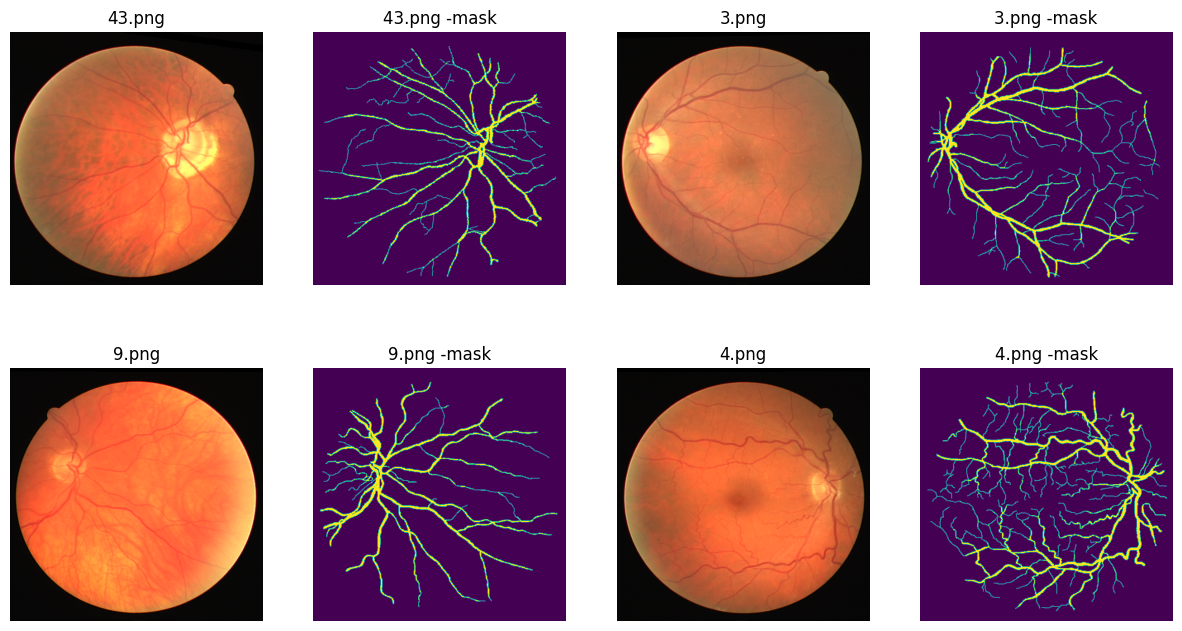

In [4]:
show_imgs = 4
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path) 
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask' 
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

In [5]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    # A.Normalize(p=1.0),
    # ToTensorV2(),
])

test_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(test_df)}')

len train: 80
len val: 20


In [7]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1,3,512,512))).shape

torch.Size([1, 1, 512, 512])

In [8]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        # print(f'train_acc: {acc}')
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            # print(f'val_acc: {acc}')
            epoch_iou_score += iou_score
            # size += y.shape[0]
    return epoch_loss/num_batches, epoch_iou_score/num_batches
    

In [17]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
 
loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    
    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2823, val_loss: 0.2606     train_iou_score: 0.587, val_iou_score: 0.621     lr: 0.001


  2%|█▌                                                                              | 1/50 [02:54<2:22:11, 174.12s/it]

EPOCH: 002     train_loss: 0.2611, val_loss: 0.2527     train_iou_score: 0.605, val_iou_score: 0.618     lr: 0.001


  6%|████▊                                                                           | 3/50 [08:45<2:17:15, 175.23s/it]

EPOCH: 003     train_loss: 0.2545, val_loss: 0.3303     train_iou_score: 0.608, val_iou_score: 0.522     lr: 0.001
EPOCH: 004     train_loss: 0.2484, val_loss: 0.2314     train_iou_score: 0.613, val_iou_score: 0.641     lr: 0.001


 10%|████████                                                                        | 5/50 [15:15<2:20:45, 187.67s/it]

EPOCH: 005     train_loss: 0.2442, val_loss: 0.3184     train_iou_score: 0.617, val_iou_score: 0.528     lr: 0.001
EPOCH: 006     train_loss: 0.2398, val_loss: 0.2248     train_iou_score: 0.621, val_iou_score: 0.643     lr: 0.001


 12%|█████████▌                                                                      | 6/50 [18:32<2:19:53, 190.77s/it]

EPOCH: 007     train_loss: 0.2393, val_loss: 0.2210     train_iou_score: 0.621, val_iou_score: 0.648     lr: 0.001


 14%|███████████▏                                                                    | 7/50 [21:48<2:17:55, 192.47s/it]

EPOCH: 008     train_loss: 0.2353, val_loss: 0.2176     train_iou_score: 0.626, val_iou_score: 0.653     lr: 0.001


 16%|████████████▊                                                                   | 8/50 [25:04<2:15:25, 193.46s/it]

EPOCH: 009     train_loss: 0.2324, val_loss: 0.2174     train_iou_score: 0.629, val_iou_score: 0.652     lr: 0.001


 20%|███████████████▊                                                               | 10/50 [31:47<2:11:48, 197.71s/it]

EPOCH: 010     train_loss: 0.2354, val_loss: 0.2351     train_iou_score: 0.625, val_iou_score: 0.630     lr: 0.0001
EPOCH: 011     train_loss: 0.2386, val_loss: 0.2084     train_iou_score: 0.620, val_iou_score: 0.663     lr: 0.0001


 22%|█████████████████▍                                                             | 11/50 [35:02<2:08:04, 197.04s/it]

EPOCH: 012     train_loss: 0.2318, val_loss: 0.2076     train_iou_score: 0.629, val_iou_score: 0.665     lr: 0.0001


 24%|██████████████████▉                                                            | 12/50 [38:21<2:05:05, 197.52s/it]

EPOCH: 013     train_loss: 0.2279, val_loss: 0.2053     train_iou_score: 0.634, val_iou_score: 0.668     lr: 0.0001


 28%|██████████████████████                                                         | 14/50 [44:54<1:58:11, 196.97s/it]

EPOCH: 014     train_loss: 0.2286, val_loss: 0.2057     train_iou_score: 0.634, val_iou_score: 0.667     lr: 0.0001
EPOCH: 015     train_loss: 0.2279, val_loss: 0.2039     train_iou_score: 0.634, val_iou_score: 0.670     lr: 0.0001


 32%|█████████████████████████▎                                                     | 16/50 [51:29<1:51:54, 197.50s/it]

EPOCH: 016     train_loss: 0.2284, val_loss: 0.2051     train_iou_score: 0.634, val_iou_score: 0.668     lr: 0.0001


 34%|██████████████████████████▊                                                    | 17/50 [54:48<1:48:45, 197.74s/it]

EPOCH: 017     train_loss: 0.2287, val_loss: 0.2047     train_iou_score: 0.633, val_iou_score: 0.669     lr: 0.0001


 36%|████████████████████████████▍                                                  | 18/50 [58:08<1:45:54, 198.58s/it]

EPOCH: 018     train_loss: 0.2276, val_loss: 0.2041     train_iou_score: 0.635, val_iou_score: 0.670     lr: 0.0001


 38%|█████████████████████████████▎                                               | 19/50 [1:01:26<1:42:29, 198.36s/it]

EPOCH: 019     train_loss: 0.2264, val_loss: 0.2042     train_iou_score: 0.636, val_iou_score: 0.670     lr: 0.0001


 38%|█████████████████████████████▎                                               | 19/50 [1:04:44<1:45:38, 204.46s/it]

EPOCH: 020     train_loss: 0.2268, val_loss: 0.2043     train_iou_score: 0.636, val_iou_score: 0.669     lr: 1e-05
Earlystop!


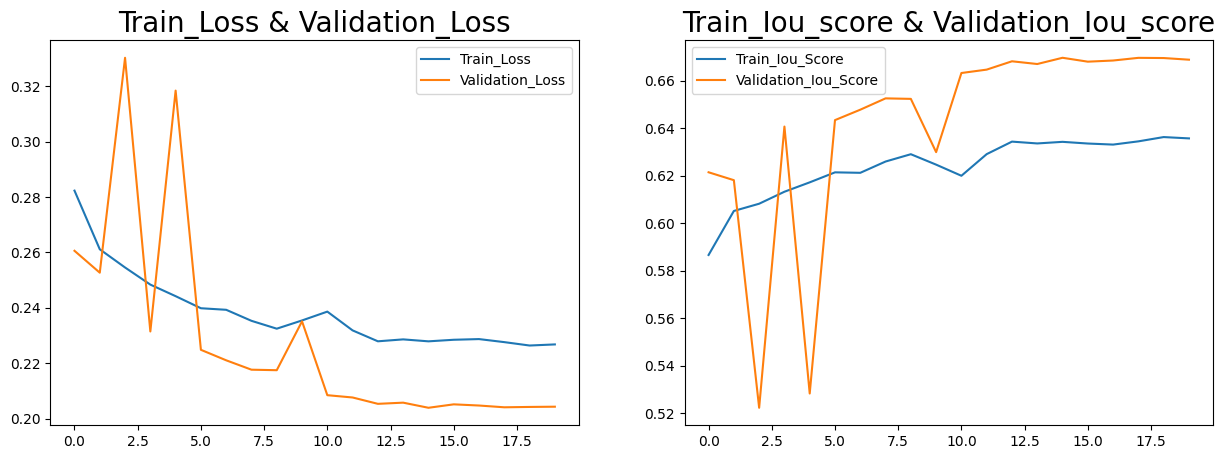

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [19]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)

In [20]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.to(device)

def get_metrics(model, dataloder, threshold):
    IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
    batchs = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloder):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            batchs += 1
    IoU_score = round(IoU_score/batchs, 3)
    precision = round(precision/batchs, 3)
    f1_score = round(f1_score/batchs, 3)
    recall = round(recall/batchs, 3)
    acc = round(acc/batchs, 3)
    sample = {'iou':IoU_score, 'pre':precision, 'fi':f1_score, 're':recall, 'acc':acc}
    return sample
    
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    f1_score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")

threshold: 0.3     IoU Score: 0.667     precision: 0.776     f1_score: 0.800     Recall: 0.829     Acc: 0.964
threshold: 0.4     IoU Score: 0.669     precision: 0.787     f1_score: 0.802     Recall: 0.821     Acc: 0.965
threshold: 0.5     IoU Score: 0.670     precision: 0.797     f1_score: 0.803     Recall: 0.813     Acc: 0.965
threshold: 0.6     IoU Score: 0.671     precision: 0.806     f1_score: 0.803     Recall: 0.804     Acc: 0.966
threshold: 0.7     IoU Score: 0.671     precision: 0.816     f1_score: 0.803     Recall: 0.794     Acc: 0.966


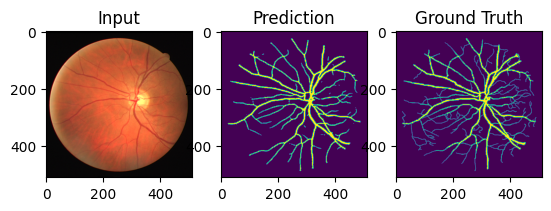

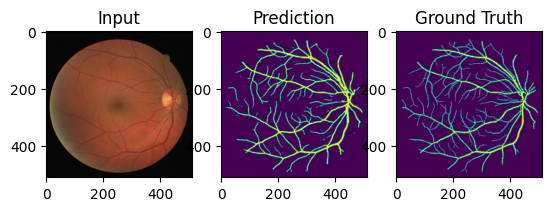

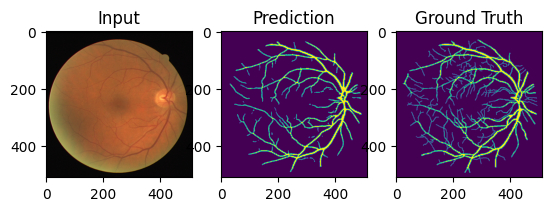

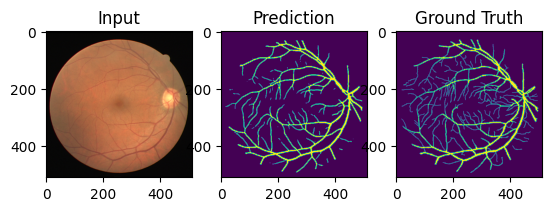

In [21]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
device = torch.device('cpu')  # Use CPU device
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to(device, dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.numpy()
    pred = np.where(pred < 0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('Prediction')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('Ground Truth')
    plt.show()
